In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns 
from scipy.stats import pearsonr, spearmanr

# Gene Expression via SNPs: Linear Regression

### Read in data

In [2]:
expression_file = "/vol/data/ouologuems/systems_genetics/data/datasets/GD660.GeneQuantRPKM.txt"
test_set_file = "/vol/data/ouologuems/systems_genetics/data/datasets/phase3_top10/5_fold_cv_split.tsv"

Read in genotypes:

In [3]:
test_set = pd.read_csv(test_set_file, sep="\t")

In [4]:
genotypes = pd.read_csv("/vol/data/ouologuems/systems_genetics/data/datasets/phase3_top10/variants_subset.tsv", sep="\t").drop(columns=["REF", "ALT", "QUAL", "FILTER", "INFO",	"FORMAT"])
genotypes = pd.melt(genotypes, id_vars=["#CHROM", "POS", "ID"], var_name="sample_id", value_name="genotype")
genotypes["#CHROM"] = genotypes["#CHROM"].astype(str)
genotypes["POS"] = genotypes["POS"].astype(str)
genotypes.loc[genotypes.ID==".", 'ID'] = "snp_" + genotypes["#CHROM"] + "_" + genotypes.POS
genotypes = genotypes.drop(columns=["#CHROM", "POS"])
genotypes.genotype = genotypes['genotype'].str.split(':',expand=True)[0] 
conditions = [
    (genotypes['genotype'] == '0|0'), (genotypes['genotype'] == '1|0'), (genotypes['genotype'] == '0|1'), (genotypes['genotype'] == '1|1')]
choices = [0, 1, 1, 2]
genotypes['GT_encoding'] = np.select(conditions, choices)
#genotypes = pd.merge(test_set.drop(columns=["sample_id", "gene_id"]).drop_duplicates(), genotypes, left_on=["patient"], right_on=["sample_id"])
genotypes

,ID,sample_id,genotype,GT_encoding
0,rs9999724,HG00096,0|0,0
1,snp_6_32552087,HG00096,0|1,1
2,snp_6_32629257,HG00096,1|1,2
3,snp_6_32634306,HG00096,1|1,2
4,rs9899833,HG00096,0|1,1
...,...,...,...,...
6547,snp_6_32552087,NA20828,1|0,1
6548,snp_6_32629257,NA20828,1|1,2
6549,snp_6_32634306,NA20828,1|1,2
6550,rs9899833,NA20828,1|1,2


Read in embeddings to get the GENE IDs: 

In [5]:
embeddings = pd.read_pickle("/vol/data/ouologuems/systems_genetics/data/datasets/phase3_top10/embeddings_complete.pickle")
sample_id = []
gene_id = []
embedding = []
for i in range(0, len(embeddings), 2):
    sid = embeddings[i][0].split(':')[1]
    gid = embeddings[i][0].split(':')[2]
    sample_id.append(sid)
    gene_id.append(gid)
    # combined_embedding = np.concatenate([embeddings[i][1], embeddings[i+1][1]]) # concatenate 2 embeddings
    combined_embedding = np.array(embeddings[i][1] + embeddings[i+1][1]) # element-wise sum of 2 embeddings
    embedding.append(combined_embedding)
df = pd.DataFrame({"sample_id": sample_id, "gene_id": gene_id, "embedding": embedding})

Read in expression data: 

In [6]:
expression = pd.read_csv(expression_file, sep="\t")
expression = expression[expression["Gene_Symbol"].isin(df["gene_id"].values)]
expression = pd.melt(expression, id_vars=["TargetID", "Gene_Symbol", "Chr", "Coord"], var_name="sample_id", value_name="expression")
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0] + "." + expression["sample_id"].str.split(".", expand=True)[1]
data = pd.merge(test_set, expression, left_on=["gene_id", "sample_id"], right_on=["Gene_Symbol", "sample_id"])
data = pd.merge(genotypes, data, left_on=["sample_id"], right_on=["patient"])
data = data.drop(columns=["Chr", "TargetID", "Coord", "Gene_Symbol"])
#data.rename(columns={"sample_id_y":"sample_id"}, inplace=True)
data.head()

,ID,sample_id_x,genotype,GT_encoding,sample_id_y,patient,gene_id,test_split,expression
0,rs9999724,HG00096,0|0,0,HG00096.1,HG00096,ENSG00000214425.1,3,0.40868
1,rs9999724,HG00096,0|0,0,HG00096.1,HG00096,ENSG00000176681.9,3,6.34823
2,rs9999724,HG00096,0|0,0,HG00096.1,HG00096,ENSG00000179344.11,3,43.78876
3,rs9999724,HG00096,0|0,0,HG00096.1,HG00096,ENSG00000232629.4,3,9.96245
4,rs9999724,HG00096,0|0,0,HG00096.1,HG00096,ENSG00000238083.3,3,7.90419


### Run Linear Regression

In [10]:
splits_train = {}
splits_test = {}
for i in range(1, 6):
    r_values_train = {} # for each snp: dict of genes 
    r_values_test = {}
    for snp in data.ID.unique():
        # extract data
        snp_df = data[data.ID == snp]
        snp_df_train = snp_df[snp_df.test_split != i]
        snp_df_test = snp_df[snp_df.test_split == i]
        snp_values_train = {}
        snp_values_test = {}
        # fuer jedes snp jedes gen 
        for gene in data.gene_id.unique():
            snp_gene_train = snp_df_train[snp_df_train.gene_id == gene]
            snp_gene_test = snp_df_test[snp_df_test.gene_id == gene]
            X_train = np.array(snp_gene_train["GT_encoding"]).reshape(-1, 1)
            X_test = np.array(snp_gene_test["GT_encoding"]).reshape(-1, 1)
            y_train = np.array(snp_gene_train.expression)
            y_test = np.array(snp_gene_test.expression)

            # train model
            model = LinearRegression().fit(X_train, y_train)

            # evaluate model on test set
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            snp_values_train[gene] = spearmanr(y_train, y_pred_train)[0]
            snp_values_test[gene] = spearmanr(y_test, y_pred_test)[0]

            # plot results on training set
            #plt.scatter(X_train, y_train)
            #plt.title("Genotype vs gene expression")
            #plt.show()
            #plt.scatter(y_train, y_pred_train)
            #plt.title(f"gene {gene} y_true vs. y_pred training set")
            #plt.show()
            #plt.scatter(y_test, y_pred_test)
            #plt.title(f"gene {gene} y_true vs. y_pred test set")
            #plt.show()
        r_values_train[snp] = snp_values_train
        r_values_test[snp] = snp_values_test
    splits_train[i] = r_values_train
    splits_test[i] = r_values_test

In [11]:
splits_train 

{1: {'rs9999724': {'ENSG00000214425.1': 0.13291744305643904,
   'ENSG00000176681.9': 0.014932792318639074,
   'ENSG00000179344.11': 0.011951188138077084,
   'ENSG00000232629.4': 0.11472618955679481,
   'ENSG00000238083.3': 0.021094463434817565,
   'ENSG00000237541.3': 0.0996364630331677,
   'ENSG00000196735.6': 0.058229001475836054,
   'ENSG00000229450.2': 0.4952458511459009,
   'ENSG00000196126.6': 0.05264421292005463,
   'ENSG00000198502.5': 0.06659955431291863},
  'snp_6_32552087': {'ENSG00000214425.1': 0.026845735717532678,
   'ENSG00000176681.9': 0.080326795256983,
   'ENSG00000179344.11': 0.30327105915049213,
   'ENSG00000232629.4': 0.10097609712835158,
   'ENSG00000238083.3': 0.1270337706358218,
   'ENSG00000237541.3': 0.16096974421111251,
   'ENSG00000196735.6': 0.3059808714326447,
   'ENSG00000229450.2': 0.12073573063198711,
   'ENSG00000196126.6': 0.27899259862453407,
   'ENSG00000198502.5': 0.052753906036013286},
  'snp_6_32629257': {'ENSG00000214425.1': 0.039895677164787785

In [12]:
splits_test

{1: {'rs9999724': {'ENSG00000214425.1': 0.0435515890414809,
   'ENSG00000176681.9': 0.07592622160328971,
   'ENSG00000179344.11': -0.05607748854456169,
   'ENSG00000232629.4': -0.0529941902053418,
   'ENSG00000238083.3': 0.08787400266776677,
   'ENSG00000237541.3': 0.07218772236698559,
   'ENSG00000196735.6': -0.07207209867926485,
   'ENSG00000229450.2': 0.5691383321907508,
   'ENSG00000196126.6': -0.05916078688378157,
   'ENSG00000198502.5': 0.04385991887540289},
  'snp_6_32552087': {'ENSG00000214425.1': -0.01859624204819412,
   'ENSG00000176681.9': 0.05888809981928138,
   'ENSG00000179344.11': 0.08884871200803858,
   'ENSG00000232629.4': 0.3894879584538435,
   'ENSG00000238083.3': 0.1405049399196889,
   'ENSG00000237541.3': 0.36985859184741643,
   'ENSG00000196735.6': 0.12087557331326178,
   'ENSG00000229450.2': 0.01239749469879608,
   'ENSG00000196126.6': -0.02789436307229118,
   'ENSG00000198502.5': -0.14876993638555297},
  'snp_6_32629257': {'ENSG00000214425.1': -0.021777881816710

### Extract and plot data

In [15]:
splits_test.items()

dict_items([(1, {'rs9999724': {'ENSG00000214425.1': 0.0435515890414809, 'ENSG00000176681.9': 0.07592622160328971, 'ENSG00000179344.11': -0.05607748854456169, 'ENSG00000232629.4': -0.0529941902053418, 'ENSG00000238083.3': 0.08787400266776677, 'ENSG00000237541.3': 0.07218772236698559, 'ENSG00000196735.6': -0.07207209867926485, 'ENSG00000229450.2': 0.5691383321907508, 'ENSG00000196126.6': -0.05916078688378157, 'ENSG00000198502.5': 0.04385991887540289}, 'snp_6_32552087': {'ENSG00000214425.1': -0.01859624204819412, 'ENSG00000176681.9': 0.05888809981928138, 'ENSG00000179344.11': 0.08884871200803858, 'ENSG00000232629.4': 0.3894879584538435, 'ENSG00000238083.3': 0.1405049399196889, 'ENSG00000237541.3': 0.36985859184741643, 'ENSG00000196735.6': 0.12087557331326178, 'ENSG00000229450.2': 0.01239749469879608, 'ENSG00000196126.6': -0.02789436307229118, 'ENSG00000198502.5': -0.14876993638555297}, 'snp_6_32629257': {'ENSG00000214425.1': -0.021777881816710077, 'ENSG00000176681.9': 0.11460935872354183,

In [28]:
split_df = []
snp_df = []
gene_df = []
rvalue_df = []
for split, results in splits_test.items():
    for snp, snp_results in results.items():
        for gene, rvalue in snp_results.items(): 
            split_df.append(split)
            snp_df.append(snp)
            gene_df.append(gene)
            rvalue_df.append(rvalue)
test_df = pd.DataFrame({"split": split_df,"snp": snp_df, "gene_id": gene_df, "rvalue": rvalue_df})

In [30]:
split_df = []
snp_df = []
gene_df = []
rvalue_df = []
for split, results in splits_train.items():
    for snp, snp_results in results.items():
        for gene, rvalue in snp_results.items(): 
            split_df.append(split)
            snp_df.append(snp)
            gene_df.append(gene)
            rvalue_df.append(rvalue)
train_df = pd.DataFrame({"split": split_df,"snp": snp_df, "gene_id": gene_df, "rvalue": rvalue_df})

In [31]:
test_df.head(), train_df.head()

(   split        snp             gene_id    rvalue
 0      1  rs9999724   ENSG00000214425.1  0.043552
 1      1  rs9999724   ENSG00000176681.9  0.075926
 2      1  rs9999724  ENSG00000179344.11 -0.056077
 3      1  rs9999724   ENSG00000232629.4 -0.052994
 4      1  rs9999724   ENSG00000238083.3  0.087874,
    split        snp             gene_id    rvalue
 0      1  rs9999724   ENSG00000214425.1  0.132917
 1      1  rs9999724   ENSG00000176681.9  0.014933
 2      1  rs9999724  ENSG00000179344.11  0.011951
 3      1  rs9999724   ENSG00000232629.4  0.114726
 4      1  rs9999724   ENSG00000238083.3  0.021094)

Plot data: 

In [34]:
train_df.gene_id = train_df.gene_id.astype("category")
test_df.gene_id = test_df.gene_id.astype("category")

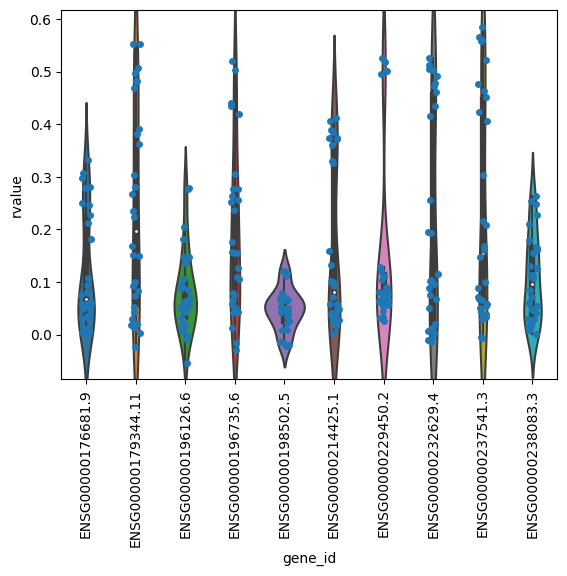

In [37]:
sns.violinplot(x = "gene_id", y ="rvalue", data=train_df)
sns.stripplot(x = "gene_id", y ="rvalue", data=train_df)#, size=0.8) 
plt.xticks(rotation = 90)
plt.show()

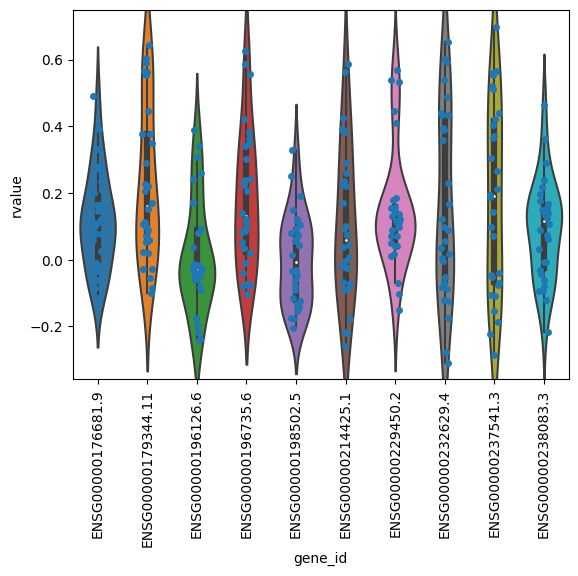

In [38]:
sns.violinplot(x = "gene_id", y ="rvalue", data=test_df)
sns.stripplot(x = "gene_id", y ="rvalue", data=test_df)#, size=0.8) 
plt.xticks(rotation = 90)
plt.show()